In [1]:
#https://cloud.google.com/ml-engine/docs/notebooks/dependencies

In [2]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)

Using TensorFlow backend.


In [3]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn import metrics

In [53]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [5]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
n_clusters = len(np.unique(y))
x.shape

(70000, 784)

In [6]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x)

In [7]:
metrics.adjusted_rand_score(y,y_pred_kmeans)

0.3651913455607028

In [8]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
autoencoder, encoder = autoencoder(dims, init=init)

Instructions for updating:
Colocations handled automatically by placer.


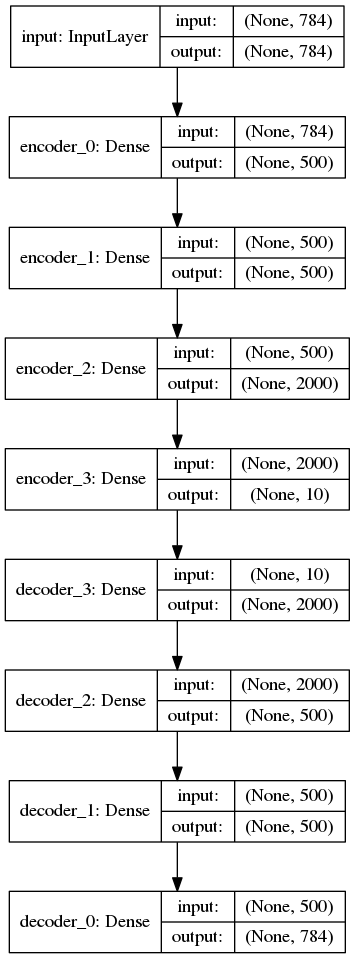

In [9]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

In [10]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
70000/70000 [==============================] - 8s 118us/step - loss: 0.0647
Epoch 2/300
70000/70000 [==============================] - 1s 19us/step - loss: 0.0424
Epoch 3/300
70000/70000 [==============================] - 1s 20us/step - loss: 0.0310
Epoch 4/300
70000/70000 [==============================] - 1s 19us/step - loss: 0.0261
Epoch 5/300
70000/70000 [==============================] - 1s 19us/step - loss: 0.0238
Epoch 6/300
70000/70000 [==============================] - 1s 19us/step - loss: 0.0223
Epoch 7/300
70000/70000 [==============================] - 1s 19us/step - loss: 0.0211
Epoch 8/300
70000/70000 [==============================] - 1s 19us/step - loss: 0.0203
Epoch 9/300
70000/70000 [==============================] - 1s 19us/step - loss: 0.0195
Epoch 10/300
70000/70000 [==============================] - 1s 19us/step - loss: 0.0189
Epoch 11/300
70000/70000 [==============================] - 1s 20us/step - loss:

In [11]:
save_dir = './results'
autoencoder.save_weights(save_dir + '/ae_weights.h5')


In [12]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

In [13]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [14]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

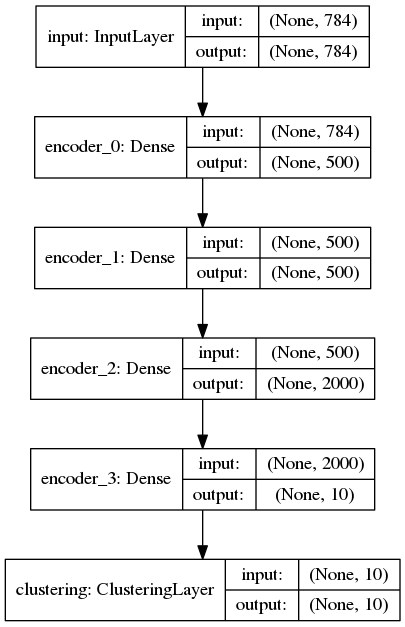

In [15]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [16]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')


In [17]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))


In [18]:
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [19]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [20]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.0001 # tolerance threshold to stop training


In [23]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            nmi = np.round(metrics.adjusted_mutual_info_score(y, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: nmi = %.5f, ari = %.5f' % (ite, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


('Iter 0: nmi = 0.82633, ari = 0.82480', ' ; loss=', 0)
('Iter 140: nmi = 0.83986, ari = 0.84574', ' ; loss=', 0.04411)
('Iter 280: nmi = 0.85792, ari = 0.86765', ' ; loss=', 0.15482)
('Iter 420: nmi = 0.87170, ari = 0.88377', ' ; loss=', 0.21107)
('Iter 560: nmi = 0.88055, ari = 0.89382', ' ; loss=', 0.22192)
('Iter 700: nmi = 0.88567, ari = 0.89925', ' ; loss=', 0.21791)
('Iter 840: nmi = 0.88982, ari = 0.90402', ' ; loss=', 0.21565)
('Iter 980: nmi = 0.89376, ari = 0.90808', ' ; loss=', 0.2119)
('Iter 1120: nmi = 0.89623, ari = 0.91069', ' ; loss=', 0.1989)
('Iter 1260: nmi = 0.89798, ari = 0.91256', ' ; loss=', 0.19956)
('Iter 1400: nmi = 0.89961, ari = 0.91429', ' ; loss=', 0.19396)
('Iter 1540: nmi = 0.90030, ari = 0.91499', ' ; loss=', 0.18557)
('Iter 1680: nmi = 0.90113, ari = 0.91583', ' ; loss=', 0.17831)
('Iter 1820: nmi = 0.90246, ari = 0.91707', ' ; loss=', 0.18446)
('Iter 1960: nmi = 0.90350, ari = 0.91821', ' ; loss=', 0.1721)
('Iter 2100: nmi = 0.90410, ari = 0.91874', 

In [25]:
model.load_weights(save_dir + '/DEC_model_final.h5')
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    nmi = np.round(metrics.adjusted_mutual_info_score(y, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('nmi = %.5f, ari = %.5f' % (nmi, ari), ' ; loss=', loss)

('nmi = 0.90869, ari = 0.92286', ' ; loss=', 0.09837)


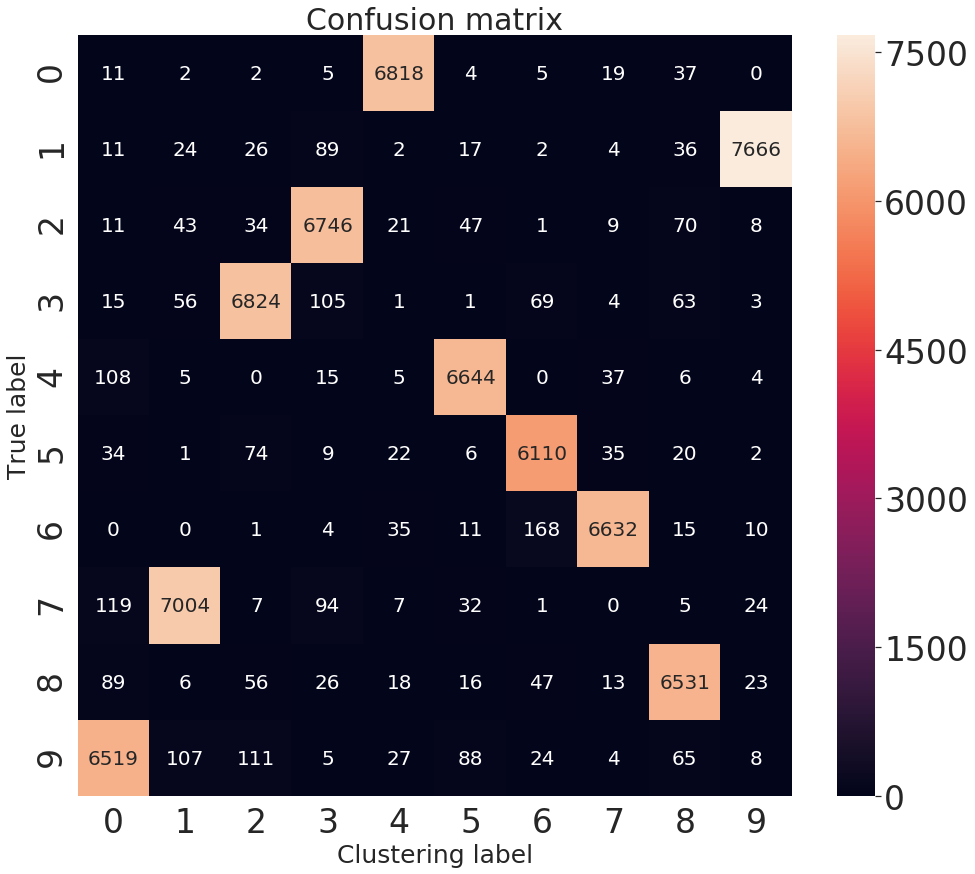

In [26]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()


In [27]:
## convolutional auto encoder

In [28]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np

In [29]:
def autoencoderConv2D_1(input_shape=(28, 28, 1), filters=[32, 64, 128, 10]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [30]:
def autoencoderConv2D_2(img_shape=(28, 28, 1)):
    """
    Conv2D auto-encoder model.
    Arguments:
        img_shape: e.g. (28, 28, 1) for MNIST
    return:
        (autoencoder, encoder), Model of autoencoder and model of encoder
    """
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    shape_before_flattening = K.int_shape(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    x = Flatten()(x)
    encoded = Dense(10, activation='relu', name='encoded')(x)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(encoded)
    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape(shape_before_flattening[1:])(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [31]:
autoencoder, encoder = autoencoderConv2D_1()
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
embedding (Dense)            (None, 10)                11530     
_________________________________________________________________
dense_1 (Dense)              (None, 1152)              12672     
__________

In [32]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape(x.shape + (1,))
x = np.divide(x, 255.)

In [33]:
pretrain_epochs = 300
batch_size = 256
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')


Epoch 1/300
70000/70000 [==============================] - 6s 79us/step - loss: 0.0800
Epoch 2/300
70000/70000 [==============================] - 2s 34us/step - loss: 0.0609
Epoch 3/300
70000/70000 [==============================] - 2s 33us/step - loss: 0.0446
Epoch 4/300
70000/70000 [==============================] - 2s 34us/step - loss: 0.0355
Epoch 5/300
70000/70000 [==============================] - 2s 33us/step - loss: 0.0306
Epoch 6/300
70000/70000 [==============================] - 2s 33us/step - loss: 0.0279
Epoch 7/300
70000/70000 [==============================] - 2s 33us/step - loss: 0.0260
Epoch 8/300
70000/70000 [==============================] - 2s 34us/step - loss: 0.0247
Epoch 9/300
70000/70000 [==============================] - 2s 34us/step - loss: 0.0237
Epoch 10/300
70000/70000 [==============================] - 2s 34us/step - loss: 0.0228
Epoch 11/300
70000/70000 [==============================] - 2s 34us/step - loss: 0.0222
Epoch 12/300
70000/70000 [===============

In [34]:
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer='adam', loss='kld')

In [36]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

# start training
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            nmi = np.round(metrics.adjusted_mutual_info_score(y, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d:  nmi = %.5f, ari = %.5f' % (ite, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/conv_DEC_model_final.h5')


('Iter 0:  nmi = 0.69881, ari = 0.63864', ' ; loss=', 0.09837)
('Iter 140:  nmi = 0.71542, ari = 0.65551', ' ; loss=', 0.03311)
('Iter 280:  nmi = 0.74011, ari = 0.68105', ' ; loss=', 0.07435)
('Iter 420:  nmi = 0.76030, ari = 0.70143', ' ; loss=', 0.10422)
('Iter 560:  nmi = 0.77238, ari = 0.71251', ' ; loss=', 0.10604)
('Iter 700:  nmi = 0.78126, ari = 0.72175', ' ; loss=', 0.08119)
('Iter 840:  nmi = 0.78723, ari = 0.72725', ' ; loss=', 0.08909)
('Iter 980:  nmi = 0.79117, ari = 0.73110', ' ; loss=', 0.08997)
('Iter 1120:  nmi = 0.79551, ari = 0.73636', ' ; loss=', 0.084)
('Iter 1260:  nmi = 0.79743, ari = 0.73774', ' ; loss=', 0.07722)
('Iter 1400:  nmi = 0.79991, ari = 0.73995', ' ; loss=', 0.07761)
('Iter 1540:  nmi = 0.80197, ari = 0.74224', ' ; loss=', 0.06942)
('Iter 1680:  nmi = 0.80467, ari = 0.74661', ' ; loss=', 0.08258)
('Iter 1820:  nmi = 0.80538, ari = 0.74732', ' ; loss=', 0.07234)
('Iter 1960:  nmi = 0.80672, ari = 0.74828', ' ; loss=', 0.06764)
('Iter 2100:  nmi = 0.

In [38]:
model.load_weights(save_dir + '/conv_DEC_model_final.h5')
## Final Evaluation
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    nmi = np.round(metrics.adjusted_mutual_info_score(y, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
    loss = np.round(loss, 5)
    print(' nmi = %.5f, ari = %.5f' % (nmi, ari), ' ; loss=', loss)

(' nmi = 0.81327, ari = 0.75605', ' ; loss=', 0.03707)


In [39]:
## Model to Train clustering and autoencoder at same time (convolutional)
autoencoder, encoder = autoencoderConv2D_1()
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
                           outputs=[clustering_layer, autoencoder.output])

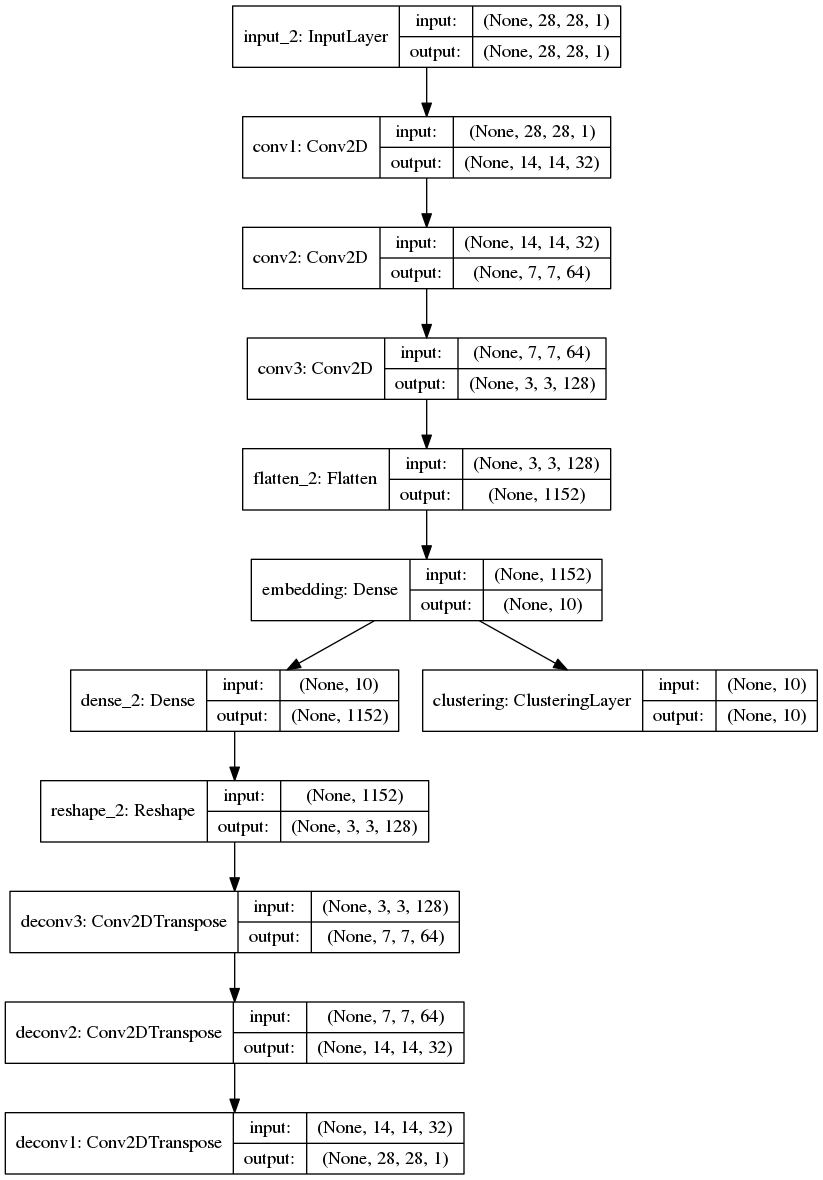

In [40]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [41]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)


In [42]:

model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

In [43]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            nmi = np.round(metrics.adjusted_mutual_info_score(y, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: nmi = %.5f, ari = %.5f' % (ite,nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/conv_b_DEC_model_final.h5')

('Iter 0: nmi = 0.69845, ari = 0.63822', ' ; loss=', 0.03707)
('Iter 140: nmi = 0.72927, ari = 0.67081', ' ; loss=', array([0.01753, 0.04489, 0.01304], dtype=float32))
('Iter 280: nmi = 0.75203, ari = 0.69256', ' ; loss=', array([0.02959, 0.1101 , 0.01858], dtype=float32))
('Iter 420: nmi = 0.76599, ari = 0.70647', ' ; loss=', array([0.03135, 0.13494, 0.01785], dtype=float32))
('Iter 560: nmi = 0.77694, ari = 0.71848', ' ; loss=', array([0.03589, 0.16367, 0.01952], dtype=float32))
('Iter 700: nmi = 0.78076, ari = 0.72274', ' ; loss=', array([0.03457, 0.12754, 0.02182], dtype=float32))
('Iter 840: nmi = 0.78612, ari = 0.72733', ' ; loss=', array([0.03364, 0.13833, 0.01981], dtype=float32))
('Iter 980: nmi = 0.79154, ari = 0.73440', ' ; loss=', array([0.03494, 0.16086, 0.01885], dtype=float32))
('Iter 1120: nmi = 0.79358, ari = 0.73560', ' ; loss=', array([0.02933, 0.11247, 0.01808], dtype=float32))
('Iter 1260: nmi = 0.79773, ari = 0.74088', ' ; loss=', array([0.03239, 0.12375, 0.02001]

In [44]:
model.load_weights(save_dir + '/conv_b_DEC_model_final.h5')
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    nmi = np.round(metrics.adjusted_mutual_info_score(y, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('nmi = %.5f, ari = %.5f' % (nmi, ari), ' ; loss=', loss)

('nmi = 0.82206, ari = 0.76617', ' ; loss=', array([0.02153, 0.06342, 0.01519], dtype=float32))


In [45]:
## Model to train clustering and autoencoder at same time (fully connected)

In [46]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
n_clusters = len(np.unique(y))
x.shape

dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './results'

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.load_weights(save_dir+'/ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
            outputs=[clustering_layer, autoencoder.output])

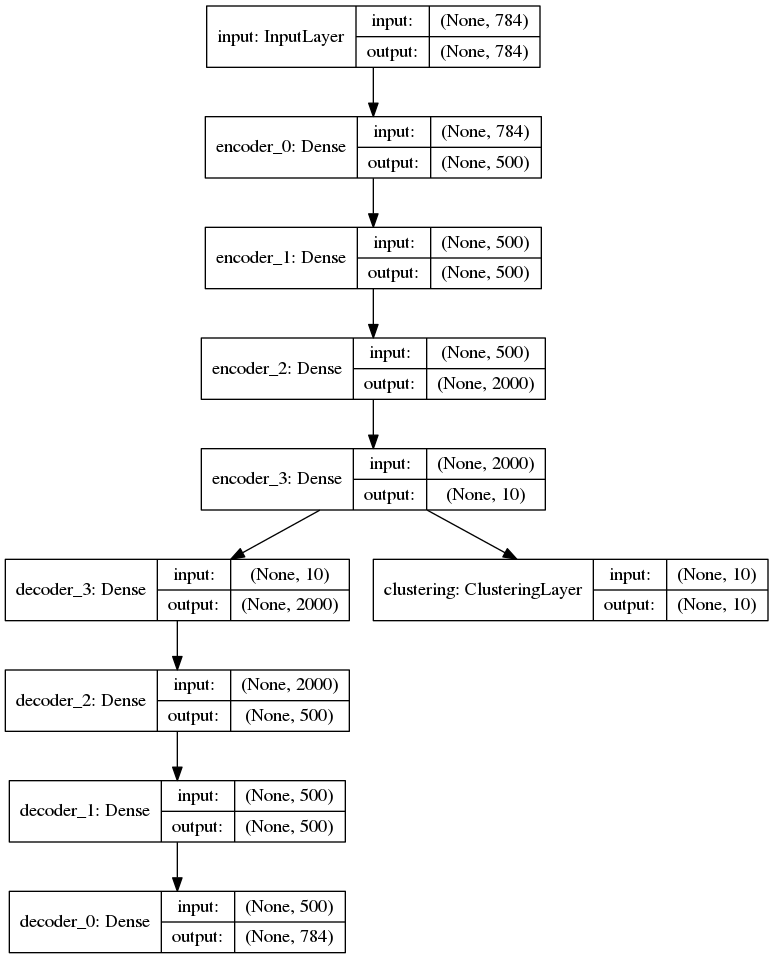

In [47]:

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [48]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)


model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [51]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            nmi = np.round(metrics.adjusted_mutual_info_score(y, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: nmi = %.5f, ari = %.5f' % (ite, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

('Iter 0: nmi = 0.82626, ari = 0.82470', ' ; loss=', array([0.02153, 0.06342, 0.01519], dtype=float32))
('Iter 140: nmi = 0.84114, ari = 0.84282', ' ; loss=', array([0.0207 , 0.04812, 0.01589], dtype=float32))
('Iter 280: nmi = 0.86363, ari = 0.87261', ' ; loss=', array([0.02731, 0.10591, 0.01672], dtype=float32))
('Iter 420: nmi = 0.87620, ari = 0.88719', ' ; loss=', array([0.03869, 0.15976, 0.02271], dtype=float32))
('Iter 560: nmi = 0.88502, ari = 0.89636', ' ; loss=', array([0.03502, 0.15689, 0.01933], dtype=float32))
('Iter 700: nmi = 0.89005, ari = 0.90170', ' ; loss=', array([0.03598, 0.15399, 0.02058], dtype=float32))
('Iter 840: nmi = 0.89519, ari = 0.90647', ' ; loss=', array([0.03395, 0.14754, 0.0192 ], dtype=float32))
('Iter 980: nmi = 0.89667, ari = 0.90763', ' ; loss=', array([0.03354, 0.14924, 0.01862], dtype=float32))
('Iter 1120: nmi = 0.89897, ari = 0.91008', ' ; loss=', array([0.03555, 0.13429, 0.02212], dtype=float32))
('Iter 1260: nmi = 0.90013, ari = 0.91131', ' ;

In [52]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    nmi = np.round(metrics.adjusted_mutual_info_score(y, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
    loss = np.round(loss, 5)
    print(' nmi = %.5f, ari = %.5f' % (nmi, ari), ' ; loss=', loss)

(' nmi = 0.90365, ari = 0.91366', ' ; loss=', array([0.01774, 0.04319, 0.01343], dtype=float32))
